# map2loop: gempy test 


## Convert stratigraphy GML to time-sorted groups and units

<font face color='red'><b>RUN  Notebooks #1 & #2  first!!<b></font>

Takes GML file produced by topology code, geology polygons, structure points and dtm to create 3D model.<br><br>
Limitations: no faults yet, no plutons yet, no dykes, no sills. Faults and plutons will come soon, sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty.

<font face color='red'>The way this loads data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


In [1]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
print(os.getcwd())

os.chdir('../map2loop')
import m2l_utils
print(os.getcwd())
#os.chdir('../')


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Preprocess data to ensure it meets gempy's requirements

In [2]:
import pandas as pd

mname='hams3' 

contacts=pd.read_csv('../test_data3/output/'+mname+'_contacts4.csv',",")
orientations=pd.read_csv('../test_data3/output/'+mname+'_orientations.csv',",")
invented_orientations=pd.read_csv('../test_data3/output/'+mname+'_empty_series_orientations.csv',",")
interpolated_orientations=pd.read_csv('../test_data3/tmp/combo_full.csv',",")
intrusive_orientations=pd.read_csv('../test_data3/output/ign_orientations_saucers.csv',",")
intrusive_contacts=pd.read_csv('../test_data3/output/ign_contacts.csv',",")
fault_contact=pd.read_csv('../test_data3/output/hams3_faults.csv',",")
fault_orientations=pd.read_csv('../test_data3/output/hams3_fault_orientations.csv',",")
all_sorts=pd.read_csv('../test_data3/tmp/hams3_all_sorts.csv',",")

all_orientations=pd.concat([orientations,invented_orientations,intrusive_orientations])
all_orientations.reset_index(inplace=True)

all_sorts.set_index('code',  inplace = True)

all_contacts=pd.concat([intrusive_contacts,contacts])
all_contacts.reset_index(inplace=True)
#display(all_contacts)
all_groups=set(all_sorts['group'])
#print(all_groups)
#display(all_contacts.formation.unique())
unique_contacts=set(all_contacts['formation'])

# Remove groups that don't have any contact info
no_contacts=[]
groups=[]
for agroup in all_groups:
    found=False
    #print('GROUP',agroup)
    for acontact in all_contacts.iterrows():
        if(all_sorts.loc[acontact[1]['formation']]['group'] in agroup):
            found=True
            break
    if(not found):
        no_contacts.append(agroup)
        print('no contacts for the group:',agroup)
    else:
        groups.append(agroup)

# Update list of all groups that have formations info

f=open('../test_data3/tmp/hams3_groups2.csv',"r")
contents =f.readlines()
f.close

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])       
no_contacts=[]
groups=[]

for i in range(1,ngroups+1):
    found=False
    #print('GROUP',agroup)
    for acontact in all_contacts.iterrows():
        if(all_sorts.loc[acontact[1]['formation']]['group'] in contents[i]):
            found=True
            break
    if(not found):
        no_contacts.append(contents[i].replace("\n",""))
        print('no contacts for the group:',contents[i].replace("\n",""))
    else:
        groups.append(contents[i].replace("\n",""))

# Make new list of groups

fgp=open('../test_data3/tmp/hams3_groups_clean.csv',"w")
fgp.write('1 '+str(len(groups))+'\n')
for i in range(0,len(groups)):
    fgp.write(contents[i+1].replace("\n","")+'\n')
fgp.close()        

# Remove orientations with no equivalent formations info

for agroup in all_groups:
    found=False
    #print('GROUP',agroup)
    for ano in all_orientations.iterrows():
        if(all_sorts.loc[ano[1]['formation']]['group'] in agroup):
            found=True
            break
    if(not found):
        no_contacts.append(agroup)
        print('no orientations for the group:',agroup)

print(no_contacts)

# Update master list of  groups and formations info

fas=open('../test_data3/tmp/hams3_all_sorts_clean.csv',"w")
fas.write('index,group number,index in group,number in group,code,group\n')
for a_sort in all_sorts.iterrows():
    #print(a_sort[0])
    if(a_sort[1]['group'] not in no_contacts):
        ostr=str(a_sort[1]['index'])+","+str(a_sort[1]['group number'])+","+str(a_sort[1]['index in group'])+","+str(a_sort[1]['number in group'])+","+a_sort[0]+","+a_sort[1]['group']+"\n"
        fas.write(ostr)
fas.close()

# Update orientation info

fao=open('../test_data3/output/'+mname+'_orientations_clean.csv',"w")
fao.write('X,Y,Z,azimuth,dip,polarity,formation\n')

for ano in all_orientations.iterrows():
    #if any(grp in all_sorts.loc[ano[1]['formation']]['group'] for grp in no_contacts):
    if(all_sorts.loc[ano[1]['formation']]['group'] in no_contacts or not ano[1]['formation'] in unique_contacts):  #fix here################################
        print('dud orientation:',ano[1]['formation'])
    else:
        ostr=str(ano[1]['X'])+","+str(ano[1]['Y'])+","+str(ano[1]['Z'])+","+\
             str(ano[1]['azimuth'])+","+str(ano[1]['dip'])+","+str(ano[1]['polarity'])+","+ano[1]['formation']+"\n"
        fao.write(ostr)

fao.close()

# Update formation info

fac=open('../test_data3/output/'+mname+'_contacts_clean.csv',"w")
fac.write('X,Y,Z,formation\n')

for acontact in all_contacts.iterrows():
    if(all_sorts.loc[acontact[1]['formation']]['group'] in no_contacts):
        print('dud contact:',acontact[1]['formation'])
    else:
        ostr=str(acontact[1]['X'])+","+str(acontact[1]['Y'])+","+str(acontact[1]['Z'])+","+acontact[1]['formation']+"\n"
        fac.write(ostr)

fac.close()



no contacts for the group: A_mgn_PMI
no contacts for the group: A_mgn_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_s_PMI
no contacts for the group: A_b_PRK
no contacts for the group: A_s_PMI
no contacts for the group: A_mgn_PRK
no contacts for the group: A_b_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_mgn_PMI
no orientations for the group: A_mgn_PMI
no orientations for the group: A_mgn_PRK
['A_s_PMI', 'A_mgn_PRK', 'A_b_PRK', 'A_s_PRK', 'A_mgn_PMI', 'A_mgn_PMI', 'A_mgn_PRK']
dud orientation: P__WYd_kd
dud orientation: P__WYd_kd
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_b_PRK
dud orientation: A_s_PMI
dud orientation: A_s_PMI
dud orientation: A_s_PMI
dud orientation: A_s_PMI
dud orientation: A_s_PRK
dud orientation: A_s_PRK


## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

In [3]:
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os
geo_model = gp.create_model('gp_test')

gp.init_data(geo_model, extent=[502536, 600652, 7.458e6, 7.56e6, -3000, 1200],
    resolution = (50,50,50), 
      #path_o = './test_data/output/hams2_orientations.txt',
      path_o = '../test_data3/output/hams3_orientations_clean.csv',
      path_i = '../test_data3/output/hams3_contacts_clean.csv', default_values=True); #%%      
      #path_o = './test_data3/output/ign_orientations_saucers.csv',
      #path_i = './test_data3/output/ign_contacts.csv', default_values=True); #%%

Active grids: ['regular']


## Show example lithological points

In [4]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,595340.779975,7.475217e+06,671,0.695988,0.338964,0.500026,A_mgn_PMI_520,Default series,1,1,1.000000e-08
1,598761.529585,7.475077e+06,689,0.711287,0.338340,0.500107,A_mgn_PMI_520,Default series,1,1,1.000000e-08
2,602206.429235,7.474683e+06,638,0.726694,0.336575,0.499879,A_mgn_PMI_520,Default series,1,1,1.000000e-08
3,602720.736381,7.470769e+06,596,0.728995,0.319072,0.499691,A_mgn_PMI_520,Default series,1,1,1.000000e-08
4,594340.540554,7.472034e+06,636,0.691514,0.324727,0.499870,A_mgn_PMI_520,Default series,1,1,1.000000e-08


## Show example orientations

In [5]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
156,595340.779975,7.475217e+06,671,0.695988,0.338964,0.500026,0.043481,-0.705769,0.707107,45.0,176.474569,1.0,A_mgn_PMI_520,Default series,1,1,0.01
157,598761.529585,7.475077e+06,689,0.711287,0.338340,0.500107,0.115252,-0.697651,0.707107,45.0,170.619478,1.0,A_mgn_PMI_520,Default series,1,1,0.01
158,602206.429235,7.474683e+06,638,0.726694,0.336575,0.499879,-0.169117,-0.686585,0.707107,45.0,193.837397,1.0,A_mgn_PMI_520,Default series,1,1,0.01
159,602720.736381,7.470769e+06,596,0.728995,0.319072,0.499691,0.219783,0.672083,0.707107,45.0,18.108635,1.0,A_mgn_PMI_520,Default series,1,1,0.01
160,594340.540554,7.472034e+06,636,0.691514,0.324727,0.499870,0.431922,0.559860,0.707107,45.0,37.649577,1.0,A_mgn_PMI_520,Default series,1,1,0.01


## Plot some of this data

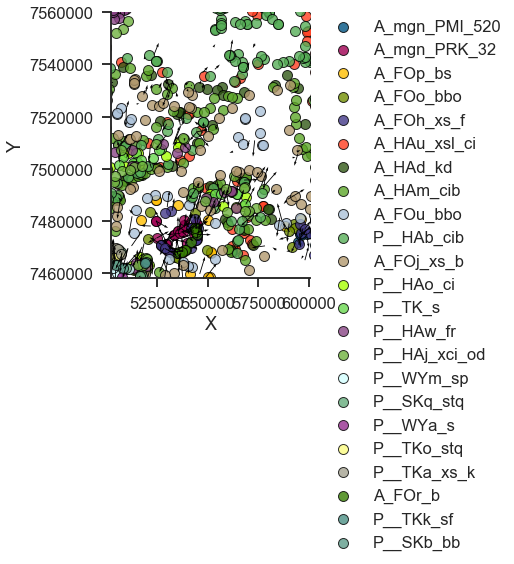

In [6]:
%matplotlib inline
gp.plot.plot_data(geo_model, direction='z');

## Load reprojected topgraphy to model

Cropped raster to geo_model.grid.extent.
[ 502536  600652 7458000 7560000] [115 110]
storing converted file...
Active grids: ['regular' 'topography']
A_mgn_PMI_520
A_mgn_PRK_32
Wyloo_Group
Shingle_Creek_Group
Turee_Creek_Group
Hamersley_Group
Fortescue_Group


,order_series,BottomRelation
A_mgn_PMI_520,1,Erosion
A_mgn_PRK_32,2,Erosion
Wyloo_Group,3,Erosion
Shingle_Creek_Group,4,Erosion
Turee_Creek_Group,5,Erosion
Hamersley_Group,6,Erosion
Fortescue_Group,7,Erosion


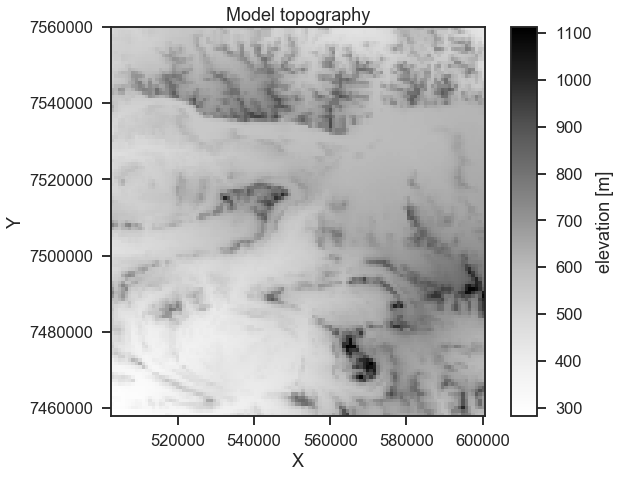

In [7]:
fp = '../test_data3/dtm/hams3_dtm_rp.tif'
geo_model.set_topography(source='gdal',filepath=fp)

## Load stratigraphic Series

f=open('../test_data3/tmp/hams3_groups_clean.csv',"r")
contents =f.readlines()
f.close


faults = gp.Faults()
series = gp.Series(faults)
series.df

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])
groups=[]

for i in range (1,int(ngroups)+1):
    groups.append(contents[i].replace("\n",""))
    series.add_series(contents[i].replace("\n",""))
    print(contents[i].replace("\n",""))

series.delete_series('Default series')

series

## Load surfaces and assign to series

In [8]:
surfaces = gp.Surfaces(series)

for i in range(0,ngroups):
    f=open('../test_data3/tmp/'+groups[i]+'.csv',"r")
    contents =f.readlines()
    nformations=str(contents[0])
    nformations=nformations.split(" ")
    nformations=int(nformations[1].replace("\n",""))

    for j in range (1,int(nformations)+1):
        surfaces.add_surface(contents[j].replace("\n",""))
        d={groups[i]:contents[j].replace("\n","")}
        surfaces.map_series({groups[i]:(contents[j].replace("\n",""))}) #working but no gps
        #gp.map_series_to_surfaces(geo_model, {groups[0]:(contents[j].replace("\n",""))},#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX<<<<
              #  set_series=True, remove_unused_series=True)
    f.close

surfaces

,surface,series,order_surfaces,isBasement,color,id
0,A_mgn_PMI_520,A_mgn_PMI_520,1,False,#015482,1
1,A_mgn_PRK_32,A_mgn_PRK_32,1,False,#9f0052,2
2,P__WYm_sp,Wyloo_Group,1,False,#ffbe00,3
3,P__WYa_s,Wyloo_Group,2,False,#728f02,4
4,P__WYd_kd,Wyloo_Group,3,False,#443988,5
5,P__SKb_bb,Shingle_Creek_Group,1,False,#ff3f20,6
6,P__SKq_stq,Shingle_Creek_Group,2,False,#325916,7
7,P__TKo_stq,Turee_Creek_Group,1,False,#5DA629,8
8,P__TKa_xs_k,Turee_Creek_Group,2,False,#acc2d9,9
9,P__TKk_sf,Turee_Creek_Group,3,False,#56ae57,10


## Set Interpolation Data

In [9]:

id_only_one_bool = geo_model.surface_points.df['id'].value_counts() == 1
id_only_one = id_only_one_bool.index[id_only_one_bool]
single_vals = geo_model.surface_points.df[geo_model.surface_points.df['id'].isin(id_only_one)]
for idx, vals in single_vals.iterrows():
    geo_model.add_surface_points(vals['X'], vals['Y'], vals['Z'], vals['surface'])
    
geo_model.update_structure()


,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[7, 37, 14, 14, 31, 66, 51, 73, 29, 115, 61, 3..."
len series surface_points,[686]
len series orientations,[200]


In [10]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


## Provide summary data on model

In [11]:
geo_model.additional_data.structure_data

,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[7, 37, 14, 14, 31, 66, 51, 73, 29, 115, 61, 3..."
len series surface_points,[686]
len series orientations,[200]


## Calculate Model

In [12]:


gp.compute_model(geo_model)

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e))



Lithology ids 
  [18. 18. 18. ...  1.  1.  1.] 

## Extract surfaces to visualize in 3D renderers

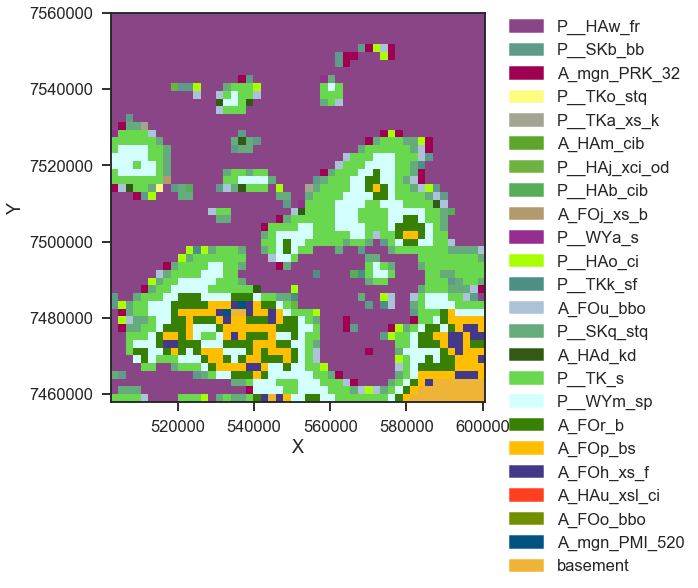

In [13]:
gp.plot.plot_section(geo_model, 49, direction='z', show_data=False)

In [14]:
ver , sim = gp.get_surfaces(geo_model)

## Visualise model

In [15]:
gp.plot.plot_3D(geo_model, show_data=False)

closing vtk


In [16]:
print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Export model to vtk files

In [17]:
from gempy import plot
gp.plot.export_to_vtk(geo_model, path='./test_data3/vtk/', name='hams3.vtk', voxels=False, block=None, surfaces=True)

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e))


True